# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
%qtconsole

In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline


In [3]:
from Timer import Timer
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import tensorflow as tf 
from tensorflow.contrib.layers import flatten
import csv

import sys
import os
import shutil
from sklearn.utils import shuffle
import json
import cv2
import random


## Utils

In [4]:
#==============================================================================
# Utils
#==============================================================================

FID = None
def setFileID(new_file_id):
    global FID
    FID = new_file_id

def print(msg="", fileOnly=False):
    global FID    
    if (type(msg) != str): msg = str(msg)
    pstr = msg if (msg.endswith("\n") or msg.startswith("\r")) else msg+"\n"
    
    if (FID is not None): 
        FID.write(pstr)
        FID.flush()
    
    if (False == fileOnly):
        sys.stdout.write(pstr)
        sys.stdout.flush()

class Utils:    

    def get_string_for_array(ar):
        varstr = '['
        for i in ar: varstr+=(i.__name__ + "-") 
    
        if (varstr.endswith('-')): varstr = varstr[0:-1]    
        varstr += ']'
        return varstr
        
    def printTestParam(EPOCHS, BATCH_SIZE, rate, save_dir='.'):
        print("------------------------------------------\n")
        print("-EPOCHS          : " + str(EPOCHS) + "\n")
        print("-BATCH_SIZE      : " + str(BATCH_SIZE) + "\n")
        print("-Save Dir        : " + save_dir + "\n")
        print("------------------------------------------\n")
        print("")    


    def find_an_empty_dir(dirname):
        v = 0
        while (True):
            tmp_name = os.path.join(dirname, "%03d"%(v))
            if (os.path.isdir(tmp_name) == False): return tmp_name
            v+=1
            
    def progressString(pcent, space=50):
        bar = '[{:' + str(space) + '}]'
        msg = "{} {:1.2f}".format(bar.format("#"* int(space * pcent)), pcent)
        return msg
    
    
    def progressPrint( epoch, valid, train=None, loss=None):
        msg = "{:3} | V {}".format(epoch, valid)
        if (train is not None): msg += " | T {}".format(train)
        if (loss  is not None): msg += " | L {}".format(loss)
        sys.stdout.write("\r" + msg)
        sys.stdout.flush()
        return msg


## ImageLoader

In [5]:
class ImageLoader:
    
    def Load_Image_Data(data_dir):
        training_file =  os.path.join(data_dir, 'train.p')
        validation_file= os.path.join(data_dir, 'valid.p')
        testing_file =   os.path.join(data_dir, 'test.p')
        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
        with open(validation_file, mode='rb') as f:
            valid = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)
        return train, test, valid


    def Read_Sign_Names(signs_file_name):
        names =[]
        if None is not signs_file_name: 
            with open(signs_file_name) as f:
                a = csv.reader(f);
                for i in a: names.append(i[1])
            
            if (len(names) > 0): names.pop(0)

        return names
    

    def __init__(self, data_dir='traffic-signs-data', label_csv_file='signnames.csv'):
        self.data_descriptor = {}
        self.data_dir=data_dir
        self.label_csv_file=label_csv_file
        self.data_descriptor.update({'data_dir': self.data_dir, 'label_file': label_csv_file})
                
        # Load data set
        train, test, valid = ImageLoader.Load_Image_Data(self.data_dir)          
        self.orgData = {'train': train, 'test': test, 'valid':valid}

        # Load Image Signs  
        self.signs = ImageLoader.Read_Sign_Names(self.label_csv_file)
        self.num_classes=len(self.signs)
        self.image_shape = train['features'][0].shape

        self.train = ImageLoader.split_data_into_classes(train['features'], train['labels'], self.num_classes)
        self.valid = ImageLoader.split_data_into_classes(valid['features'], valid['labels'], self.num_classes)
        self.test  = ImageLoader.split_data_into_classes( test['features'],  test['labels'], self.num_classes)
        self.dmap  = { 'train': self.train, 'test': self.test, 'valid': self.valid }
            
            
    def num_data(self, dataType):
        d = self.dmap[dataType]
        num_d = 0
        for i in range(self.num_classes): num_d+=len(d[i])
        return num_d
    

    def getParamDescriptor(self, desc={}): 
        desc.update({'ImageLoaderParams': self.data_descriptor})
        return desc
        
    
    def split_data_into_classes(images, labels, num_classes):
        l_data = {i:[] for i in range(num_classes)}
        for idx, label in enumerate(labels): l_data[label].append(images[idx])
        return l_data    
    
    
    def print_data_stats(self, data_type='train'):
        l_data = self.dmap[data_type]
        signs = self.signs
        print("-----------------------------------------------------------------------|")
        print("| Data : {:62.62}|".format(data_type))
        print("|                                                                      |")
        print("| Class |  Num Imgs  | Label                                           |")
        print("|----------------------------------------------------------------------|")
        for key, imgs in l_data.items():
            print("|  {:>3d}  |  {:>6d}  |  {}".format(key, len(imgs), signs[key] ))
            print("|----------------------------------------------------------------------|")
            

    def get_data_dist(self, key): return [len(self.dmap[key][ar]) for ar in self.dmap[key]]
            

    def augmentDatasetPerspective(self, dataType, num_total=2100, sz=22, delta=3, t_rng=range(-10, 10), perspTrans=False):    
        dataset = self.dmap[dataType]    
        self.data_descriptor['aug_'+dataType] = {'total_images': num_total, 'sz': sz, 'delta': delta, 't_rng':str(t_rng), 'perspTrans':perspTrans} 

        for v in (dataset):
            ims = dataset[v]
            n = len(ims)
            num_aug = num_total - n
            if (num_aug < 0): continue
    
            for idx in np.random.randint(low=0, high=n, size=num_aug):
                ims.append(ImageLoader.AugmentPerspective(ims[idx], sz=sz, delta=delta, t_rng=t_rng, perspTrans=perspTrans))
        return dataset


    def AugmentPerspective(img, sz=22, delta=3, t_rng=range(-10, 10), perspTrans=True):
        rand = lambda rng, size=None: np.random.randint(rng.start, rng.stop, size=size)
        pt2Rng  = lambda pt, d=delta: [range(i-d, i+d) for i in pt]
        getRect = lambda c=16, sz=sz: [[c - sz/2, c - sz/2], 
                                       [c + sz/2, c - sz/2],
                                       [c + sz/2, c + sz/2],
                                       [c - sz/2, c + sz/2]] 
        
    
        pts = np.int32(getRect(sz=sz))
        dst = [[rand(pt2Rng(pt, d=delta)[0]), rand(pt2Rng(pt, d=delta)[1])] for pt in pts]
        pts, dst = np.float32(pts), np.float32(dst) + np.float32([rand(t_rng), rand(t_rng)])   
        mat = cv2.getPerspectiveTransform(pts, dst) if perspTrans else cv2.getAffineTransform(pts[:3,:], dst[:3,:])
    
        dst = np.zeros_like(img)        
        if (len(img.shape) == 2): 
            if (perspTrans): 
                return cv2.warpPerspective(img, mat, (img.shape[0], img.shape[1]), borderMode=cv2.BORDER_REPLICATE) 
            else: 
                return cv2.warpAffine(img, mat, (img.shape[0], img.shape[1]), borderMode=cv2.BORDER_REPLICATE) 
        if (len(img.shape) == 3):     
            for i in range(img.shape[2]):
                if (perspTrans): 
                    dst[:, :, i] = cv2.warpPerspective(img[:,:,i], mat, (img.shape[0], img.shape[1]), borderMode=cv2.BORDER_REPLICATE)
                else: 
                    dst[:, :, i] = cv2.warpAffine(img[:,:,i], mat, (img.shape[0], img.shape[1]), borderMode=cv2.BORDER_REPLICATE)
            return dst    
        return img    
        
    
    def plot_grid_subplot(nrows, ncols, plot_func, func_args={}, col_labels=[]):
        fig,axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, min(100000, 20*(nrows / ncols))))
        for c in range(ncols):
    
            if (c < len(col_labels)): axs[0][c].set_title('{}'.format(col_labels[c]))
            for r in range(nrows):
                plot_func(r, c, fig, axs, **func_args)
        plt.show()  
    

    def plot_data(self, dataType='train', classes=None, n_per_class=5):
        if (classes is None): classes = random.sample(range(0,self.num_classes), 5)    
        data = self.dmap[dataType]
        n_classes = len(classes)        
        im_grid = {}
        for j, k in enumerate(classes):
            images = data[k]
            im_idx = np.random.randint(low=0, high=len(images), size=n_per_class)
            pstr = "Class: {:2d} | ".format(k)
            for i in im_idx: pstr+=" {:5d}".format(i)
            print(pstr)
            im_grid[j] = [images[im_idx[i]] for i in range(n_per_class)]         
    
        
        func = lambda r, c, fig, axs, ims: [axs[r][c].imshow(basicNorm(ims[c][r])), axs[r][c].axis('off')]
        ImageLoader.plot_grid_subplot(n_per_class, n_classes, func, {'ims': im_grid})       
        
        
    def visualize(self, setname='train', classes=None):        
        data = self        
        dataset = data.dmap[setname]
        if (classes is None): classes = range(self.num_classes)
        signnames = data.signs
        col_width = max(len(name) for name in signnames)
        class_counts = data.get_data_dist(setname)
        
        for c in classes:
            X_train = dataset[c]
            c_count = len(X_train)
            c_index = 0
            
            print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
            fig = pyplot.figure(figsize = (6, 1))
            fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
            random_indices = random.sample(range(c_index, c_index + c_count), 10)
            for i in range(10):
                axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
                axis.imshow(basicNorm(X_train[random_indices[i]]))
                    
            pyplot.show()
            print("--------------------------------------------------------------------------------------\n")
    
    
    def plot_histogram(self, setname='train'):
        class_counts = self.get_data_dist(setname)
        pyplot.bar( np.arange( self.num_classes ), class_counts, align='center' )
        pyplot.xlabel('Class')
        pyplot.ylabel('Number of {} examples'.format(setname))
        pyplot.xlim([-1, self.num_classes])
        pyplot.show()

        
    
    def CreateDataSet(self, pcent_train=1.0, pcent_test=1.0, pcent_valid=1.0):
        
        train, test, valid = {'features': [], 'labels': []}, {'features': [], 'labels': []}, {'features': [], 'labels': []}
        
        dst =   [train,       test,       valid]
        src =   [self.train,  self.test,  self.valid]
        pcent = [pcent_train, pcent_test, pcent_valid]

        for j in range(3):        
            dataDst, dataSrc = dst[j], src[j]
            for i in range(self.num_classes):
                dataDst['features'] += dataSrc[i]
                dataDst['labels']   += [i]* len(dataSrc[i])
            
            n_sample = len(dataDst['features'])
            pcent_tk = pcent[j]            
            idx = range(0, n_sample) if (pcent_tk == 1.0) else random.sample(range(0, n_sample), int(n_sample * pcent_tk))
                        
            dataDst['features'] = np.take(dataDst['features'], idx, axis=0, mode='raise').astype(np.float32)
            dataDst['labels'  ] = np.take(dataDst['labels'],   idx, axis=0, mode='raise').astype(np.uint8)
            
        return train, test, valid

    
def basicNorm(img):
    shape = img.shape
    dst = np.float32(img)
    if (len(shape) == 2):
            p  = dst
            p -= p.min()
            p /= p.max()        
    else:
        for i in range(shape[2]): 
            p  = dst[:, :, i]
            p -= p.min()
            p /= p.max()

    return dst 

## Network

In [6]:

def CalcOutputSize(in_x, k_x, s_x, valid=True):
    m = (k_x - 1) if valid else 0
    return math.ceil(float(in_x - m) / float(s_x))

def GetOutputSize(inSize, kSize, stride, paddingValid=True):
    w = CalcOutputSize(inSize[1], kSize[1], stride[1], paddingValid)
    h = CalcOutputSize(inSize[2], kSize[2], stride[2], paddingValid)
    c = kSize[0]
    return (w, h, c)


class Network(object):
    
    def __init__(self, name = "Default"):
        self.name = name
        self.descriptor = {}      
        self.train_feed, self.eval_feed = {}, {}
        self.layers = []
        
    def getParamDescriptor(self, desc={}): 
        desc.update({'Network_'+self.name : self.descriptor})
        return desc
    
    def getSaveDir(self): return None
    def getLogFilePath(self): return None

    def fully_connected(x, num_outs, mu=0.0, sigma=1.0, name=None, dtype=np.float32):
        num_ins = x.shape.as_list()[-1]        
        Ws = tf.Variable(tf.truncated_normal((num_ins, num_outs), mean=mu, stddev=sigma, name=name, dtype=dtype))
        Bs = tf.Variable(np.zeros((num_outs,)), dtype=dtype)
        return tf.matmul(x, Ws) + Bs
        
    def conv2d(x, fh, fw, fd, strides=[1, 1, 1, 1], padding='VALID', mu=0.0, sigma=1.0, name=None, dtype=np.float32):
        (_, xh, xw, xc) = x.shape.as_list()
        F_W = tf.Variable(tf.truncated_normal(shape=(fh, fw, xc, fd), mean=mu, stddev=sigma, name=None), dtype=dtype)
        F_b = tf.Variable(np.zeros((fd, )), dtype=dtype)
        return tf.nn.conv2d(x, F_W, strides, padding) + F_b
    
    def addDropOut(layer, keep_prob, train_feed, eval_feed, name=None):
        if ( 0 < keep_prob < 1 ):
            kp = tf.placeholder(tf.float32, name=name)
            train_feed.update({kp: keep_prob})
            eval_feed.update({kp: 1.0})
            return tf.nn.dropout(layer, keep_prob=kp)
        return layer
    
    def add(self, layer):
        lastLayer = self.layers[-1] if len(self.layers) > 0 else None
        if (layer is not None and layer != lastLayer): self.layers.append(layer)
        return layer

    def strTensor(b): return "Tensor {:20s} shape={}".format(b.name, str(b.get_shape()))

    
        

## Trainer

In [7]:
class Trainer(object):

    def getImageShape(x): pass

    def __init__(self, train, test, valid, signs, num_classes, network, args={}, rate=0.001, EPOCHS=10, BATCH_SIZE=256):
        self.X_train, self.y_train = train['features'].copy(), train['labels']
        self.X_valid, self.y_valid = valid['features'].copy(), valid['labels']
        self.X_test,  self.y_test  =  test['features'].copy(),  test['labels']
        self.image_shape = self.X_train[0].shape
        self.signs = signs
        self.num_classes = num_classes

        self.x  = tf.placeholder(tf.float32, (None,) + self.image_shape)
        self.y = tf.placeholder(tf.uint8, (None))
        one_hot_y = tf.one_hot(self.y, self.num_classes)
        
        # init network
        self.network = network(self.x, self.num_classes, **args)    
        logits = self.network.layers[-1]
        self.train_feed, self.eval_feed = self.network.train_feed, self.network.eval_feed
        # Init Train Pipeline
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)        

        # Init Eval Pipeline
        self.correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        self.saver = tf.train.Saver()

        self.one_hot_y, self.logits = one_hot_y, logits
        self.print_data_info()
        self.descriptor = {'rate': rate, 'EPOCHS': EPOCHS, 'BATCH_SIZE': BATCH_SIZE}
        self.saved_model_path = None
        
    def print_data_info(self):
        num_data = {'train': len(self.y_train), 'test': len(self.y_test), 'valid': len(self.y_valid)}
        ratio_data={k:num_data[k]/num_data['train'] for k in ['train', 'test', 'valid']}
        print('---------------------------------')
        print('      '+'| Train  | Test   | Valid  |')
        print('---------------------------------')
        print(' (#)  '+"| %6d | %6d | %6d |"% (num_data['train'], num_data['test'], num_data['valid']))
        print(' (%)  '+"| %6.2f | %6.2f | %6.2f |"% (ratio_data['train'], ratio_data['test'], ratio_data['valid']))
        print('---------------------------------')
        print('Number Classes  : ' + str(self.num_classes))
        print('Image Dimensions: ' + str(self.image_shape))
        print()


    def getParamDescriptor(self, desc={}):
        desc['trainer'] = self.descriptor
        return desc

    
    def train(self, sess, dirname='results', stat_freq=30, rfunc=None):
        
        rate, EPOCHS, BATCH_SIZE = self.descriptor['rate'], self.descriptor['EPOCHS'], self.descriptor['BATCH_SIZE']
        outpath = os.path.join(dirname, "SavedModel")

        run_incomplete = True
        stats = []

        print("TrainFeed = " + str(self.train_feed))
        print("EvalFeed  = " + str(self.eval_feed))
        
        msg = lambda pcent, sp=30: Utils.progressString(pcent, space=sp)
        bar = lambda ep, valid, t=None, l=None: Utils.progressPrint(ep, valid, train=t, loss=l)

        loss_scale = 1
        
        try:            
            print("Training...")
            print()
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(self.X_train)
            validation_accuracy = -1
            
            for i in range(EPOCHS):
                tot_acc, tot_loss, tot_n = 0,0,0
                self.X_train, self.y_train = shuffle(self.X_train, self.y_train)
                for n, offset in enumerate(range(0, num_examples, BATCH_SIZE)):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = self.X_train[offset:end], self.y_train[offset:end]
                    feed_dict = {self.x: batch_x, self.y: batch_y}
                    feed_dict.update(self.train_feed)
            
                    if (n % stat_freq == (stat_freq-1)):
                        train_acc, loss_r = self.calcAccAndLoss(sess, batch_x, batch_y)
                        if (loss_scale == 1 and loss_r != 0.0): loss_scale = 1.0/loss_r
                        bar(i, msg(validation_accuracy,sp=20), t=msg(train_acc,sp=20), l=msg(loss_scale*loss_r,sp=30))
                        stats.append([validation_accuracy, n, train_acc, i, loss_r])
                        tot_acc, tot_loss, tot_n = tot_acc+train_acc, tot_loss+loss_r, tot_n + 1
                        if (rfunc is not None): rfunc(stats)
            
            
                    sess.run(self.training_operation, feed_dict=feed_dict)
            
                self.X_test, self.y_test = shuffle(self.X_test, self.y_test)
                validation_accuracy = self.evaluate(sess, self.X_test, self.y_test)
                fmsg = bar(i, msg(validation_accuracy,sp=20), t=msg(tot_acc/tot_n,sp=20), l=msg(100*(tot_loss/tot_n),sp=30))
                print("\r" + fmsg, fileOnly=True)
                print()
                
            
                
            self.saver.save(sess, outpath)
            print("Model saved : " + outpath)
            self.saved_model_path = outpath
            run_incomplete = False
        finally:
            if (run_incomplete): shutil.rmtree(dirname)

        return stats


    def evaluate(self, sess, x_data, y_data, BATCH_SIZE=128):
        
        num_examples = len(x_data)
        BATCH_SIZE = min(BATCH_SIZE, num_examples)
        total_accuracy = 0

        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            feed_dict={self.x: batch_x, self.y: batch_y}
            feed_dict.update(self.eval_feed)
            accuracy = sess.run(self.accuracy_operation, feed_dict=feed_dict)
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
                
    
    def calcLoss(self, sess, x_data, y_data, BATCH_SIZE=128):
        num_examples = len(x_data)
        BATCH_SIZE = min(BATCH_SIZE, num_examples)
        total_loss = 0
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            feed_dict={self.x: batch_x, self.y: batch_y}
            feed_dict.update(self.eval_feed)
            loss = sess.run(self.loss_operation, feed_dict=feed_dict)
            total_loss += (loss * len(batch_x))
        return loss / num_examples


    def calcAccAndLoss(self, sess, X_data, y_data):
        return self.evaluate(sess, X_data, y_data), self.calcLoss(sess, X_data, y_data)

## Methods

In [8]:

def saveData(org, dirpath):
    dirpath = Utils.find_an_empty_dir(dirpath)
    print("Saving data to: " + dirpath)
    if (os.path.exists(dirpath) == False): os.makedirs(dirpath)
    with open(os.path.join(dirpath, 'train.p'), "wb") as fp:
        pickle.dump(org.train, fp)
    with open(os.path.join(dirpath, 'test.p'), "wb" ) as fp:
        pickle.dump(org.test, fp)
    with open(os.path.join(dirpath, 'valid.p'), "wb") as fp:
        pickle.dump(org.valid, fp)


            

#from pandas import Categorical as cat
#
#def pandasData(org, isOrginialSet=False):
#    n_train, n_test, n_valid = len(org.train['labels']), len(org.test['labels']), len(org.valid['labels'])
#    train = pd.DataFrame({'label': cat(org.train['labels'], categories=range(org.num_classes)), 'sign': cat(np.take(org.signs, org.train['labels']), categories=org.signs), 'image': list(org.train['features']), 'type': cat(['train'] * n_train, categories=['train', 'test', 'valid']), 'isAugmented': [False] * n_train}, copy=False)
#    valid = pd.DataFrame({'label': cat(org.valid['labels'], categories=range(org.num_classes)), 'sign': cat(np.take(org.signs, org.valid['labels']), categories=org.signs), 'image': list(org.valid['features']), 'type': cat(['valid'] * n_valid, categories=['train', 'test', 'valid']), 'isAugmented': [False] * n_valid}, copy=False)
#    test  = pd.DataFrame({'label': cat(org.test ['labels'], categories=range(org.num_classes)), 'sign': cat(np.take(org.signs, org.test ['labels']), categories=org.signs), 'image': list(org.test ['features']), 'type': cat(['test' ] * n_test , categories=['train', 'test', 'valid']), 'isAugmented': [False] * n_test }, copy=False)
#
#    train_test_valid_set = pd.Series([train, test, valid], index=['train', 'test', 'valid'], copy=False)
#    full_set = pd.concat([train, test, valid], ignore_index=True, copy=False)    
#    class_set = pd.Series([full_set[full_set.label == i] for i in range(org.num_classes)], copy=False)
#    return full_set, class_set, train_test_valid_set


In [9]:
    

# #%% LOAD THE DATA

# data_dir = os.path.join("aug1K_sz26_d3_rng3_persp", "000")
# training_file = os.path.join(data_dir, "train.p")
# validation_file = os.path.join(data_dir, "valid.p")
# testing_file = os.path.join(data_dir, "test.p")





# #org, data = Timer.run(loadData)
# #full_set, class_set, ttv_set = pandasData(org)
# #
# #org, data = augmentData(org, data, num_total=1000)    


---
## Step 0: Load The Data

In [10]:
def loadData(dirpath='traffic-signs-data'):
    data  = ImageLoader(data_dir=dirpath)
    return data

org_data = loadData()


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [11]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = org_data.num_data('train')

# TODO: Number of testing examples.
n_test = org_data.num_data('test')

# TODO: What's the shape of an traffic sign image?
image_shape = org_data.image_shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = org_data.num_classes

print("Number of training examples = "+ str(n_train))
print("Number of testing examples = " +  str(n_test))
print("Image data shape = " + str(image_shape))
print("Number of classes = " + str(n_classes))

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

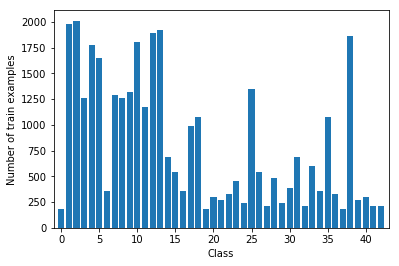

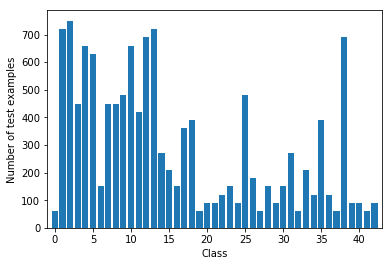

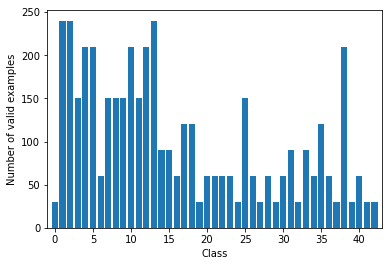

Class 28: Children crossing                                   480 samples


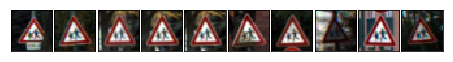

--------------------------------------------------------------------------------------
Class 22: Bumpy road                                          330 samples


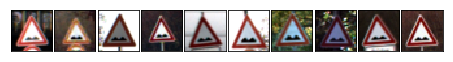

--------------------------------------------------------------------------------------
Class 27: Pedestrians                                         210 samples


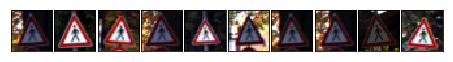

--------------------------------------------------------------------------------------
Class 24: Road narrows on the right                           240 samples


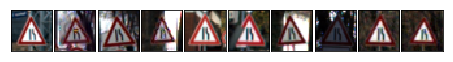

--------------------------------------------------------------------------------------
Class 18: General caution                                     1080 samples


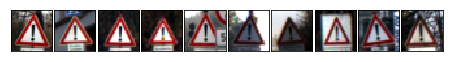

--------------------------------------------------------------------------------------


In [12]:
org_data.plot_histogram('train')
org_data.plot_histogram('test')
org_data.plot_histogram('valid')

org_data.visualize('train', classes=random.sample(range(0, org_data.num_classes), 5))



## Augment Data

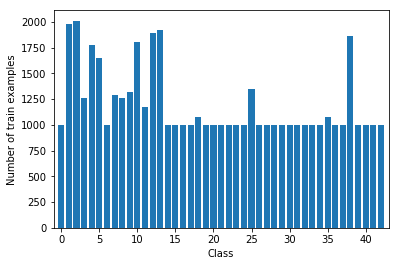

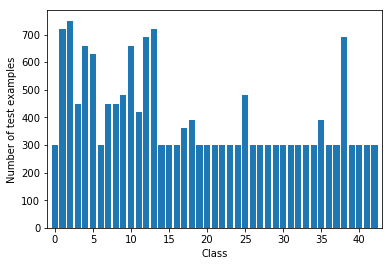

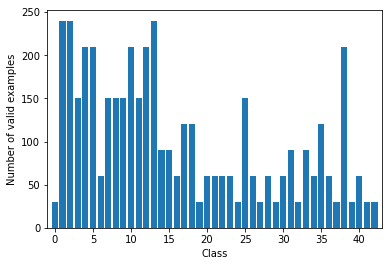

Class 25: Road work                                           1350 samples


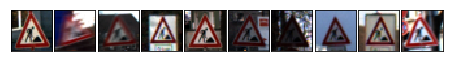

--------------------------------------------------------------------------------------
Class 27: Pedestrians                                         1000 samples


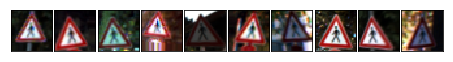

--------------------------------------------------------------------------------------
Class 32: End of all speed and passing limits                 1000 samples


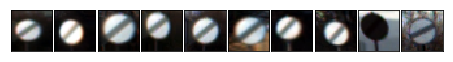

--------------------------------------------------------------------------------------
Class 42: End of no passing by vehicles over 3.5 metric tons  1000 samples


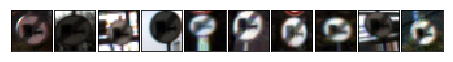

--------------------------------------------------------------------------------------
Class 36: Go straight or right                                1000 samples


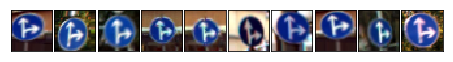

--------------------------------------------------------------------------------------


In [13]:
def augmentData(data, num_total=1000, save_dir=None, sz=26, delta=3, t_rng=range(-3, 3), perspTrans=True):
    ''' 
        augments data set by random transformations. Augments all data set [train, test, valid]
            num_train = num_total
            num_test  = 0.3 * num_total
            num_valid = 0.1 * num_total
            
            num_total : minimum number of samples per class after augmentation
            save_dir  : optionally save the augmented set to disk for later use
            sz        : its a hyperparameter, describes the size of the inner square that is used to generate
                        the affine or perspective transform in the images.
            t_rng     : range of pixels to vary the translation factor
            perspTrans: True to do a 4 point perspective transform or 3-point affine transform
    '''
    n_train,n_test,n_valid = num_total, np.int(num_total*0.3), np.int(num_total*0.1)
    data.augmentDatasetPerspective('train', num_total=n_train, sz=sz, delta=delta, t_rng=t_rng, perspTrans=perspTrans)
    data.augmentDatasetPerspective('test',  num_total=n_test , sz=sz, delta=delta, t_rng=t_rng, perspTrans=perspTrans)
#     data.augmentDatasetPerspective('valid', num_total=n_valid, sz=sz, delta=delta, t_rng=t_rng, perspTrans=perspTrans)

    
## Run augmentation
augmentData(data=org_data, num_total=1000, save_dir=None, sz=26, delta=3, t_rng=range(-3, 3), perspTrans=True)

## Re-render the data
org_data.plot_histogram('train')
org_data.plot_histogram('test')
org_data.plot_histogram('valid')
org_data.visualize('train', classes=random.sample(range(0, org_data.num_classes), 5))


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [14]:
class LeNetWithDropOut(Network):
    
    def __init__(self, x, num_outputs, mu=0.0, sigma=0.1, dropouts={}):        
        Network.__init__(self, "LeNetWithDropOut" )
        train_feed, eval_feed = {}, {}
        
        tensor = None
        
        self.add(x)
        
        Layer = 0       # Convolutional. Input = 32x32x3. Output = 28x28x6.
        tensor = self.add(Network.conv2d(x, 5, 5, 6, strides = [1, 1, 1, 1], padding='VALID', mu=mu, sigma=sigma))
        tensor = self.add(tf.nn.relu(tensor))
        if (Layer in dropouts): tensor = self.add(Network.addDropOut(tensor, dropouts[Layer], train_feed, eval_feed))
        tensor = self.add(tf.nn.max_pool(tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'))
            
        Layer = 1       # Convolutional. Input = 32x32x3. Output = 28x28x6
        tensor = self.add(Network.conv2d(tensor, 5, 5, 16, strides=[1, 1, 1, 1], padding='VALID', mu=mu, sigma=sigma))
        tensor = self.add(tf.nn.relu(tensor))
        if (Layer in dropouts): tensor = self.add(Network.addDropOut(tensor, dropouts[Layer], train_feed, eval_feed))
        tensor = self.add(tf.nn.max_pool(tensor, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'))
    
        Layer = 2       # Flatten. Input = 5x5x16. Output = 400.
        tensor = self.add(flatten(tensor))
        if (Layer in dropouts): tensor = self.add(Network.addDropOut(tensor, dropouts[Layer], train_feed, eval_feed))
    
        Layer = 3       # Layer 3: Fully Connected. Input = 400. Output = 120.
        tensor = self.add(Network.fully_connected(tensor, 120, mu, sigma))
        tensor = self.add(tf.nn.relu(tensor))
        if (Layer in dropouts): tensor = self.add(Network.addDropOut(tensor, dropouts[Layer], train_feed, eval_feed))
    
        Layer = 4       # Fully Connected. Input = 120. Output = 84
        tensor = self.add(Network.fully_connected(tensor, 84, mu, sigma))
        tensor = self.add(tf.nn.relu(tensor))
        if (Layer in dropouts): tensor = self.add(Network.addDropOut(tensor, dropouts[Layer], train_feed, eval_feed))
    
        Layer = 5     # Fully Connected. Input = 84. Output = 43.
        tensor = self.add(Network.fully_connected(tensor, num_outputs, mu, sigma))

        self.train_feed, self.eval_feed = train_feed, eval_feed
    
        self.updateDescriptor(args={'mu': mu, 'sigma': sigma, 'dropouts': dropouts})


    def updateDescriptor(self, args={}):
        self.descriptor['LeNetParams'] = args
        tstring = {}
        for i, t in enumerate(self.layers): tstring["{:2}".format(i)] = Network.strTensor(t)
        self.descriptor['LeNetArch'] = tstring                               


## Make data copy and create model trainer

In [15]:
def convertToGrayScale(data):
    grays = []
    for i in range(len(data)):
        bw = cv2.cvtColor(data[i], cv2.COLOR_RGB2GRAY)
        grays.append(bw.reshape(bw.shape + (1,)))
    return grays


# make a copy of the data set and create RGB and Gray DataSets
def CreateDataSets(data):
    train, test, valid = data.CreateDataSet()
    train_gray, test_gray, valid_gray = {'labels':train['labels']}, {'labels':test['labels']}, {'labels':valid['labels']}
    
    train_gray['features'] = convertToGrayScale(train['features'])
    test_gray[ 'features'] = convertToGrayScale(test[ 'features'])
    valid_gray['features'] = convertToGrayScale(valid['features'])
        
    RGB_data ={'train': train,      'test': test,      'valid': valid}
    Gray_data={'train': train_gray, 'test': test_gray, 'valid': valid_gray}
    return RGB_data, Gray_data

RGB_data, Gry_data = CreateDataSets(org_data)

### Pre-process the Data Set (normalization, grayscale, etc.)


## Preprocessing Routines

In [16]:

def Center_Data(src, i, dst):
    dst[i] = (src[i] - 128.0)/128.0

def Center_MaxNorm(src, i, dst):
    sh = src[i].shape
    if (len(sh) == 3):
        for c in range(3): 
            dst[i][:,:,c] = (src[i][:,:,c]/(0.5*np.max(src[i][:,:,c])))-1.0
    else:
        dst[i] = (src[i]/(0.5*np.max(src[i])))-1.0
        

def normImage(src, i, dst): dst[i] = basicNorm(src[i])

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

## Evaluation Routines

In [69]:
def evaluate_test_images(sess, model, x_data, y_data, BATCH_SIZE=128):

    num_examples = len(x_data)
    BATCH_SIZE = min(BATCH_SIZE, num_examples)

    results   = np.zeros((model.num_classes, model.num_classes), dtype=np.float32)
    pred_indx = np.zeros((model.num_classes, model.num_classes), dtype=np.float32)
    n_samples = np.zeros((model.num_classes))

    num = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        feed_dict={model.x: batch_x, model.y: batch_y}
        feed_dict.update(model.eval_feed)
        predict = sess.run(tf.nn.softmax(model.logits), feed_dict=feed_dict)

        amax=np.argmax(predict, axis=1)
        for i, c in enumerate(batch_y):
            results[c, :] += predict[i, :]
            pred_indx[c, amax[i]]+=1
            n_samples[c]+=1

        num+=1

    return results, pred_indx, n_samples


# data, signs = org_data.valid, org_data.signs
def plot_eval_results(pred_indx, n_samples, data, signs):

    cper = pred_indx/n_samples.reshape((43,1))
    top3 = np.stack((np.argsort(cper, axis=1)[:,-3:], np.sort(cper, axis=1)[:,-3:]), axis=2)
    getImage = lambda x: [random.sample(data[i], 1)[0] for i in x]

    # for im_class, t3 in enumerate(top3):
    for kk in np.argsort(np.max(cper, axis=1)):
        im_class, t3 = kk, top3[kk]
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
        ims = getImage(t3[:,0])

        acc = cper[im_class][im_class]*100
        fig.suptitle('Class {:2d} | Acc {:5.2f} % | {:20s}'.format(im_class, acc, signs[im_class]))    

        for i, (im, t) in enumerate(zip(ims, t3)):
            ax = axs[-(i+1)]
            ax.imshow(im)
            ax.set_title('{:2d} | {:5.2f} %'.format(int(t[0]), t[1]*100))

---------------------------------
      | Train  | Test   | Valid  |
---------------------------------
 (#)  |  51690 |  17190 |   4410 |
 (%)  |   1.00 |   0.33 |   0.09 |
---------------------------------
Number Classes  : 43
Image Dimensions: (32, 32, 3)

---------------------------------
      | Train  | Test   | Valid  |
---------------------------------
 (#)  |  51690 |  17190 |   4410 |
 (%)  |   1.00 |   0.33 |   0.09 |
---------------------------------
Number Classes  : 43
Image Dimensions: (32, 32, 1)

Start
---------------------------------
      | Train  | Test   | Valid  |
---------------------------------
 (#)  |  51690 |  17190 |   4410 |
 (%)  |   1.00 |   0.33 |   0.09 |
---------------------------------
Number Classes  : 43
Image Dimensions: (32, 32, 3)

{
    "ImageLoaderParams": {
        "aug_test": {
            "delta": 3,
            "perspTrans": true,
            "sz": 26,
            "t_rng": "range(-3, 3)",
            "total_images": 300
        },
        

/Users/jabeerah/Developer/anaconda/anaconda/envs/cars/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Accuracy : 84.21


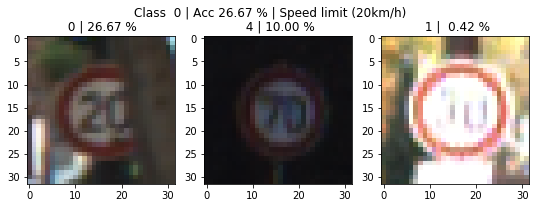

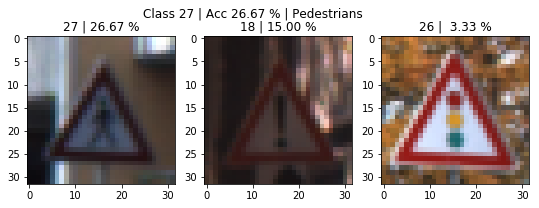

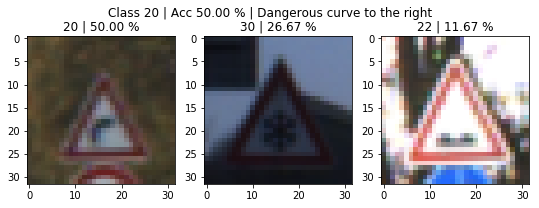

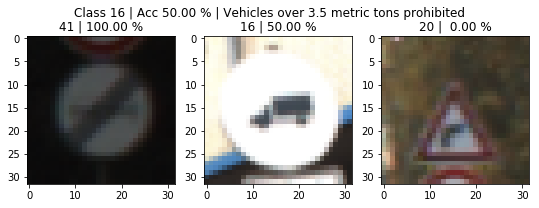

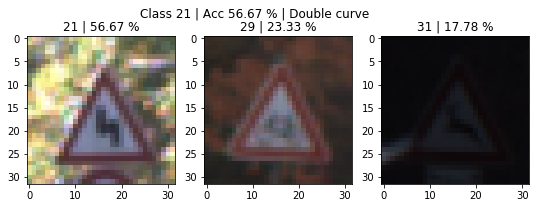

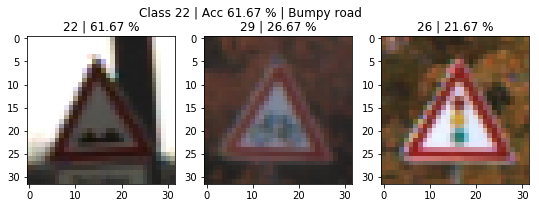

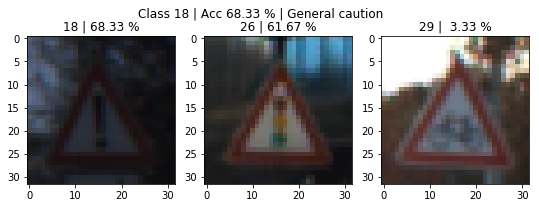

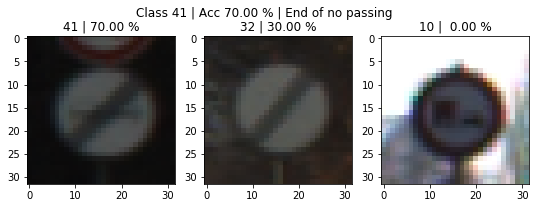

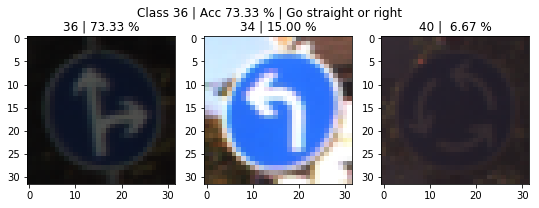

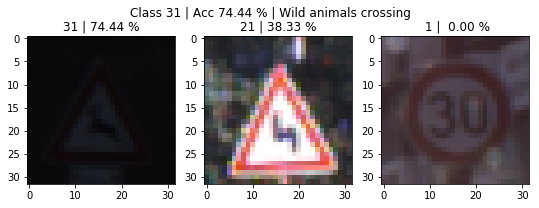

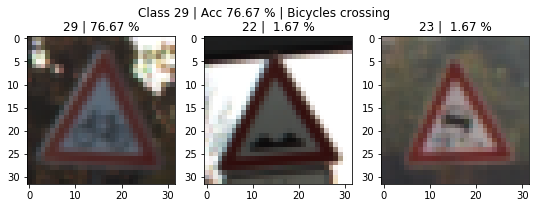

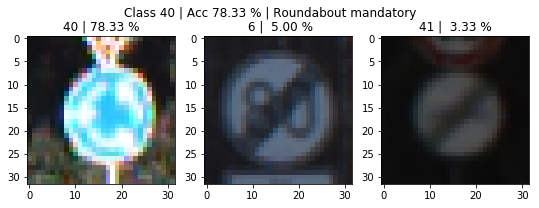

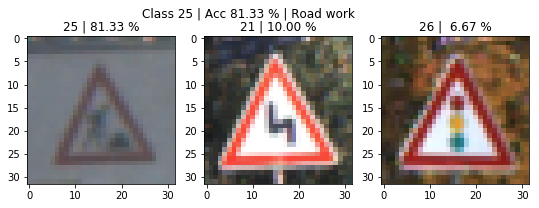

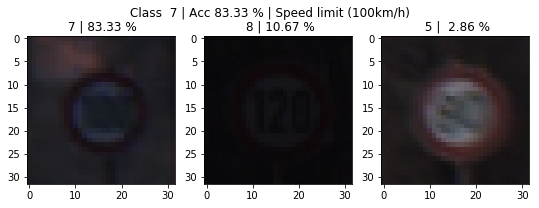

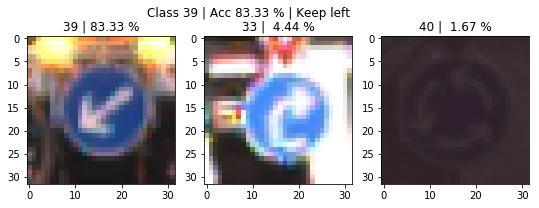

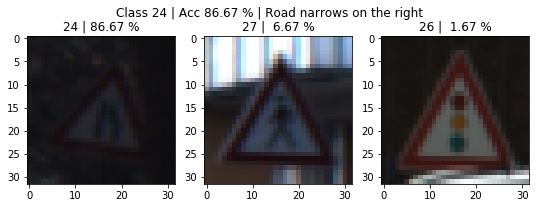

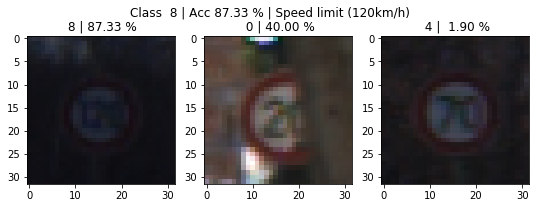

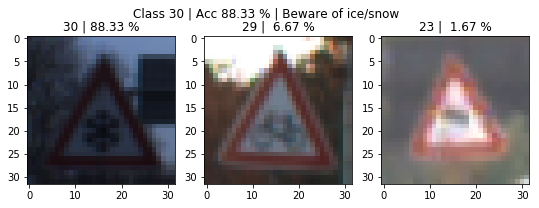

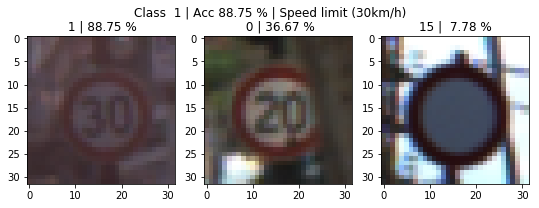

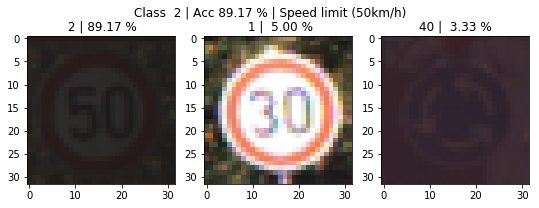

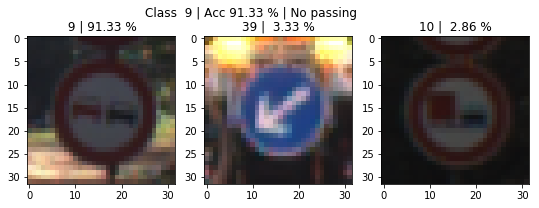

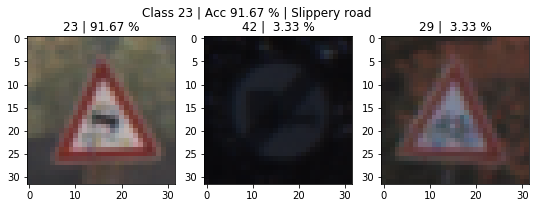

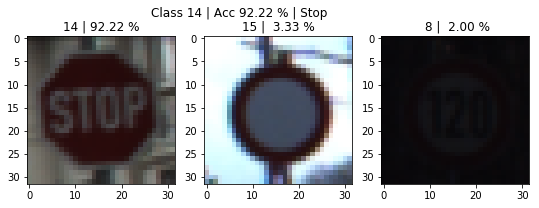

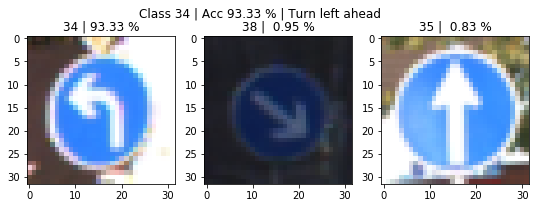

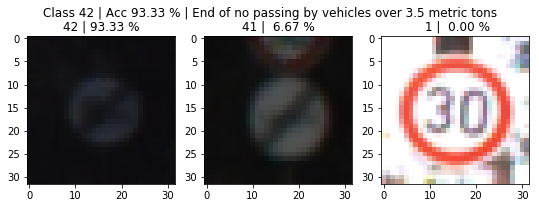

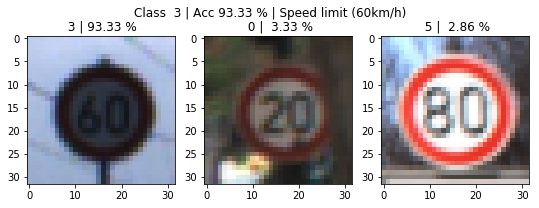

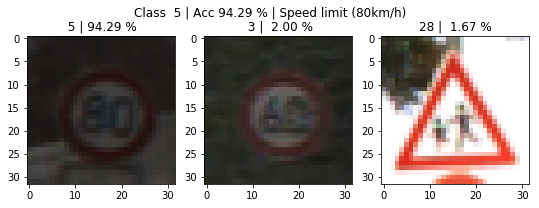

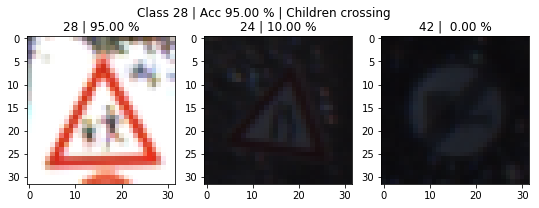

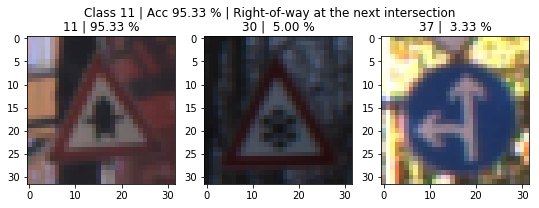

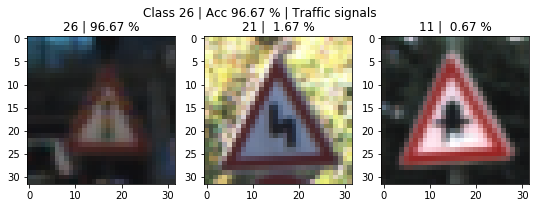

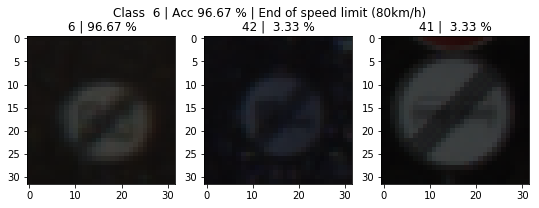

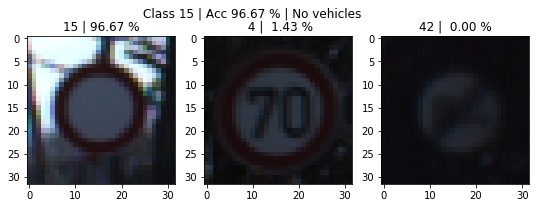

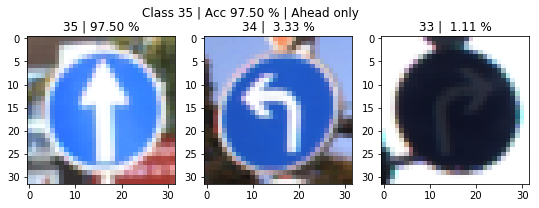

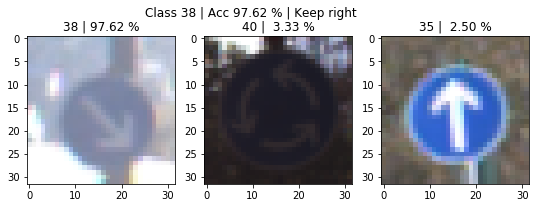

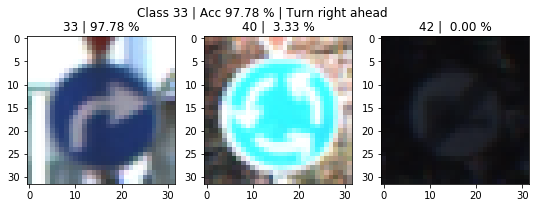

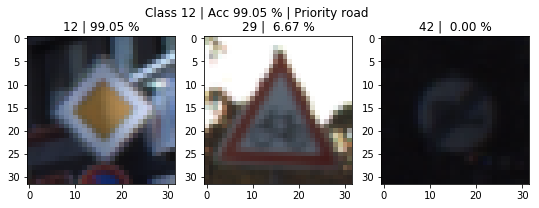

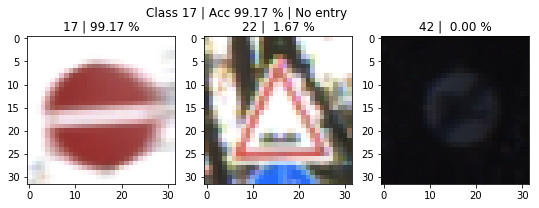

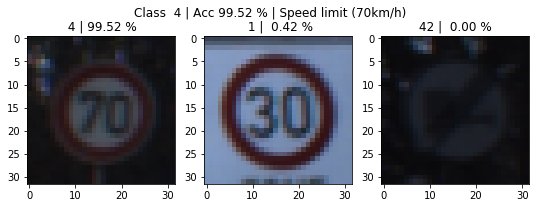

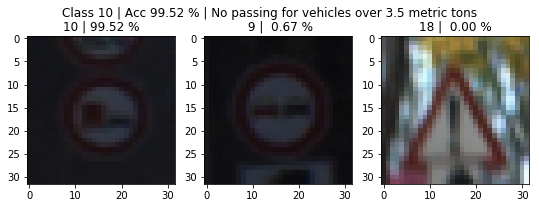

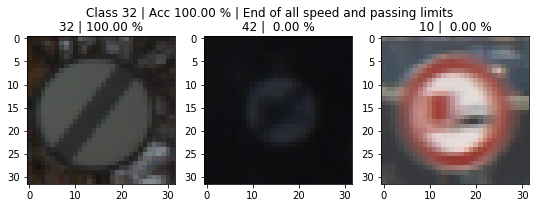

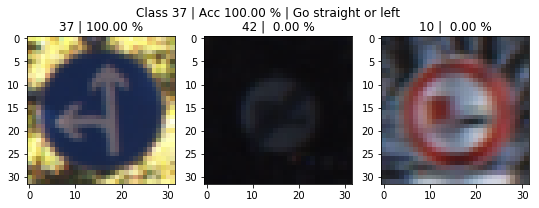

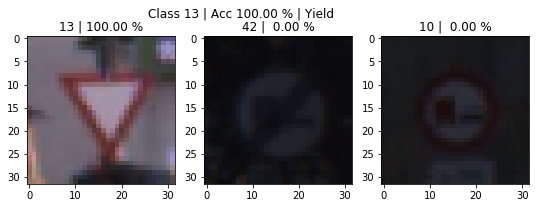

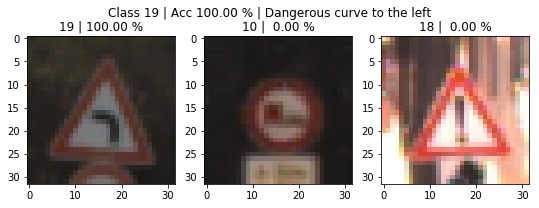

In [18]:
def merge_dicts(dicts=[]):
    mdict={}
    for d in dicts: mdict.update(dicts)
    return merge_dicts

def preprocess(src, pre_ops=[], dst=None):
    if (dst is None): dst = src
    
    for ops in pre_ops:
        for i in range(len(src)): ops(src, i, dst)

## Create Model
network_args = {'mu': 0.0, 'sigma':0.1, 'dropouts':{}}
trainer_args = { 'EPOCHS': 10, 'BATCH_SIZE': 256, 'rate': 0.001 }
rgb_model = Trainer(RGB_data['train'], RGB_data['test'], RGB_data['valid'], org_data.signs, org_data.num_classes, LeNetWithDropOut, args=network_args, **trainer_args)
gry_model = Trainer(Gry_data['train'], Gry_data['test'], Gry_data['valid'], org_data.signs, org_data.num_classes, LeNetWithDropOut, args=network_args, **trainer_args)


model = rgb_model
desc = {'model': 'rgb_model'}

global FID

## Preprocess
pre_ops = [Center_MaxNorm]
preprocess(model.X_train, pre_ops=[Center_MaxNorm])
preprocess(model.X_test,  pre_ops=[Center_MaxNorm])
preprocess(model.X_valid, pre_ops=[Center_MaxNorm])

completed = False
last_good_model = 'results/LeNetWithDropOut/015/SavedModel'

sess = None
if (sess is not None): 
    sess.close()
    sess = None

try :
    print("Start")
    # Set file logging path
    logpath = Utils.find_an_empty_dir(os.path.join('results', model.network.name))
    os.makedirs(logpath, mode=511, exist_ok=False)
    log_file = os.path.join(logpath, 'log.txt')
    FID = open(log_file, "w")
    
    # Print descriptions
    model.print_data_info()
    desc = org_data.getParamDescriptor(desc)
    desc = model.network.getParamDescriptor(desc)
    desc = model.getParamDescriptor(desc)
    print(json.dumps(desc, indent=4, sort_keys=True))
        
    sess = tf.Session()
    ## Train Here
    model.train(sess, dirname=logpath)
    completed = True
    last_good_model = model.saved_model_path
    
    ## Evaluate against test set
    res, pred_indx, n_samples = evaluate_test_images(sess, model, model.X_valid, model.y_valid, BATCH_SIZE=128)
    plot_eval_results(pred_indx, n_samples, org_data.valid, org_data.signs)
    print("Accuracy : {:5.2f}".format(np.mean(pred_indx.diagonal() / n_samples)*100))
finally:
    try:
        FID.close()
    finally:
        FID = None
        if not completed: shutil.rmtree(logpath)
    pass 



# # kEPOCHS, kBATCH_SIZE, kRATE, kNETWORK, kNETWORK_ARGS = 'EPOCHS', 'BATCH_SIZE', 'RATE', 'NETWORK', 'NETWORK_ARGS'
# # pre_ops = [Center_1to1]
# pre_ops = [Center_MaxNorm]
# org, data = Timer.run(preprocess,  args={'org': org, 'data': data, 'pre_ops':pre_ops})

# # , 'dropouts':{0: 0.9, 1:0.6}
# # args = {'D': org, 'EPOCHS': 10, 'BATCH_SIZE': 128, 'RATE': 0.001, 'NETWORK': MT.LeNet, 'NETWORK_ARGS': {'sigma':0.001}} 
# # args = {'D': org, 'EPOCHS': 15, 'BATCH_SIZE': 128, 'RATE': 0.0005, 'NETWORK': MT.LeNet, 'NETWORK_ARGS': {'sigma':0.001}} 
# args = {'D': org, 'EPOCHS': 15, 'BATCH_SIZE': 128, 'RATE': 0.001, 'NETWORK': MT.LeNetWithDropOut, 'NETWORK_ARGS': {'sigma':0.001, 'dropouts':{2: 1.0, 3: 1.0}}} 
# # args = {'D': org, 'EPOCHS': 15, 'BATCH_SIZE': 128, 'RATE': 0.001, 'NETWORK': MT.LeNetWithDropOut, 'NETWORK_ARGS': {'sigma':0.001}} 

# org, modl, stats, sdb = Timer.run(train, args=args)
# plotStatsData(sdb)

In [52]:
%qtconsole

In [ ]:
# from IPython import display
import time

def renderPlot(stats, epochs2plot=50):
#     fig, axs = None, None
#     fig, axs = figInfo if (figInfo is not None) else plt.subplots()
    if (stats is None):   return 
    if (len(stats) == 0): return 
    
#     val = np.array([stats[i][0] for i in range(len(stats))])
#     trn = np.array([stats[i][1] for i in range(len(stats))])
    stats = np.array(stats)
    val, x, trn, eps = stats[:,0], np.cumsum(stats[:,1]), stats[:,2], stats[:,3]
    val_unique, val_idx = np.unique(eps, return_index=True)
#     axs.plot(x, trn, 'r-')
#     axs.plot(x, val, 'g-')
#     plt.show()
    
#     display.display(fig)
#     display.clear_output(wait=True)
#     time.sleep(1.0)

#     plt.clf()
    plt.plot(x, [0.93]*len(x), 'b--')
    plt.plot(x, trn, 'r.-')
    plt.plot(x, val, 'g.-')
    
    epstep = np.int(max(1, len(val_idx)/epochs2plot))
    print('val_idx[:{}:]= {}'.format(epstep, val_idx[::epstep]))
    nepochs = len(val_idx)
    epochs2plot=min(nepochs, epochs2plot)
    # nepochs = np.linspace(0, np.floor(nepochs/epochs2plot)*epochs2plot, epochs2plot, dtype=np.int, endpoint=False)
    for v in val_idx[::epstep]: plt.plot([x[v], x[v]], [0, 1.0], 'y--')
    plt.grid(True)
    plt.ylim((0,1.0))
    plt.xlim((0, max(10000, max(x))))
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    time.sleep(0.5)
#     return fig, axs

### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

    
def convert_stats_to_pandas(stats):
    stats = np.array(stats)
    val = stats[:,0]
    trn = stats[:,2]
    xs  = stats[:,1].astype(np.int)
    eps = stats[:,3].astype(np.int)
    stats_db = pd.DataFrame({'itr': xs, 'val': val, 'trn':trn, 'eps':eps}, copy=True)    
    return stats_db

def plotStatsData(stats_db):
    stats_db.plot(y=['val', 'trn'], yticks=np.arange(0,1.1,0.05), grid=True)

In [ ]:
# renderPlot(stats, epochs2plot=20)
# plotStatsData(sdb)
sdb['strn'] = strn=sdb.trn.rolling(5).median()
sdb.plot(y=['strn','val'], yticks=np.arange(0.7, 1.1,0.01), grid=True, ylim=(0.85, 1.01))
# sdb.plot(y=['val'], yticks=np.arange(0.7, 1.1,0.01), grid=True, ylim=(0.85, 1.01))

In [ ]:
x_data, y_data = [], []

def evaluate(dataset, saved_model):
    

MT.Evaluate()

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 